In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import uniform, randint
from matplotlib import pyplot as plt
import re
from tqdm import tqdm
import sys

sys.path.append('..')
from fpl_predictor.util import *

In [2]:
# path to project directory
path = Path('../')

In [3]:
# read in training dataset
train_df = pd.read_csv(path/'fpl_predictor/data/train_v8.csv', 
                       index_col=0, 
                       dtype={'season':str,
                              'squad':str,
                              'comp':str})

In [4]:
# for experimenting with expected stats
# only available from 17/18 season
# train_df = train_df[train_df['season'] != '1617']

## XGBoost model

XGboost is another ensemble tree-based predictive algorithm that performs well across a range of applications. Preparation of the data is very similar to the random forest approach.

Again this is a time series problem, where metrics from recent time periods can be predicitve, so we need to add in window features (e.g. points scored last gameweek).

In [5]:
# add a bunch of player lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

In [6]:
team_lag_vars

['total_points_team_pg_last_all',
 'total_points_team_pg_last_1',
 'total_points_team_pg_last_2',
 'total_points_team_pg_last_3',
 'total_points_team_pg_last_4',
 'total_points_team_pg_last_5',
 'total_points_team_pg_last_10',
 'total_points_team_pg_last_all_opponent',
 'total_points_team_pg_last_1_opponent',
 'total_points_team_pg_last_2_opponent',
 'total_points_team_pg_last_3_opponent',
 'total_points_team_pg_last_4_opponent',
 'total_points_team_pg_last_5_opponent',
 'total_points_team_pg_last_10_opponent']

Again we have introduced the lag (window) features for each player's points per game, their team's points per game and the opposition team's points per game over the previous 1, 2, 3, 4, 5, 10 and all gameweeks.

Next we can again do everything we need to train the model, using a function to make things cleaner for the experimentation below. We do the following:

- Set the validation point and length as well as the categorical and continuous features (additional to the player and team continuous features set above) we'll be using to predict the dependent variable, total points for each game
- Various operations for ordering fields and setting categories
- Use create_lag_train function to get an our training set (including appropriate lag values in the validation set)
- Build the input (X) and dependent (y) variable datasets. Again this includes encoding the categorical features so that each level is represented in it's own column (e.g. postition_1, position_2, etc.)
- Split out training and validation datasets, limiting validation to rows with >0 minutes
- Return the training sets for use with the XGBoost API, and validation sets

In [7]:
# set validaton point/length and categorical/continuous variables
valid_season = '2021'
valid_gw = 20
valid_len = 6
cat_vars = ['season', 'position', 'was_home']
cont_vars = ['gw']#, 'minutes']
dep_var = ['total_points']

In [8]:
def xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var,
             valid_season, valid_gw, valid_len):
    
    # we want to set gw and season as ordered categorical variables
    # need lists with ordered categories
    ordered_gws = list(range(1,39))
    ordered_seasons = ['1617', '1718', '1819', '1920', '2021'] 

    # set as categories with correct order 
    lag_train_df['gw'] = lag_train_df['gw'].astype('category')
    lag_train_df['season'] = lag_train_df['season'].astype('category')

    lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
    lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)
    
    # create dataset with adjusted post-validation lag numbers
    train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)
    
    # split out dependent variable
    X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()
    
    # since position is categorical, it should be a string
    X['position'] = X['position'].apply(str)

    # need to transform season
    enc = LabelEncoder()
    X['season'] = enc.fit_transform(X['season'])
    X_dict = X.to_dict("records")

    # Create the DictVectorizer object: dv
    dv = DictVectorizer(sparse=False, separator='_')

    # Apply dv on df: df_encoded
    X_encoded = dv.fit_transform(X_dict)

    X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)
    
    # split out training and validation sets
    X_train = X_df.loc[train_idx]
    # train_mask = X_train['minutes_last_all'] > 0
    # X_train = X_train[train_mask]
    y_train = y.loc[train_idx]#[train_mask]

    X_test = X_df.loc[valid_idx]
    # we only want look at rows with >0 minutes (i.e. the player played)
#     test_mask = (X_test['minutes'] > 0) #& (X_test['total_points_pg_last_38'] > 4)
#     X_test = X_test[test_mask]
#     y_test = y.loc[valid_idx][test_mask]
    y_test = y.loc[valid_idx]
    
    return X_train, y_train, X_test, y_test

We'll also define a function to instatiate and fit an XGBoost Regressor object with some set parameters

In [9]:
# def xg(xs, y, objective="reg:squarederror", gamma=0.35, learning_rate=0.1, max_depth=3, 
#        n_estimators=200, subsample=0.87, **kwargs):
#     return xgb.XGBRegressor(n_jobs=-1, objective=objective, gamma=gamma, learning_rate=learning_rate, 
#                             max_depth=max_depth, n_estimators=n_estimators, subsample=subsample).fit(xs, y)

In [10]:
def xg(xs, y, objective="reg:squarederror", n_estimators=200, **kwargs):
    return xgb.XGBRegressor(n_jobs=-1, n_estimators=n_estimators, objective=objective).fit(xs, y)

Now lets train a model and look at the performance

In [11]:
X_train, y_train, X_test, y_test = xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, 
                                            team_lag_vars, dep_var, valid_season, valid_gw, valid_len)

# X_train = X_train.drop('minutes', axis=1)
# X_test = X_test.drop('minutes', axis=1)

m = xg(X_train, y_train)
preds = m.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.139264
MAE: 1.211636


This is another improvement on the previous best (random forest), but perhaps it can be improved by doing a parameter search.

To do this we will first define the grid of parameters to be searched.

In [12]:
# parameter search space
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0.3, 0.05),
          "learning_rate": uniform(0.12, 0.04), # default 0.1 
          "max_depth": randint(3, 6), # default 3
          "n_estimators": randint(25, 250), # default 100
          "subsample": uniform(0.7, 0.2)}

In this case we will pass both train and validation parts of the dataset, along with a series telling the XGBRegressor object which rows to use for training, and which for validation. We'll do this by recombining the train and test sets and creating a predefined split array to tell the search object what is what.

We can then again instatiate the XGBRegressor object, but this time pass it to a randomised search validation object, along with the parameter grid, validation splits, and number of iterations we want to run.

We fit this to the training data - 100 random parameter selections will be made and the best parameters for the validation set can be found (takes about 30 minutes to run for me).

In [13]:
X_train, y_train, X_test, y_test = xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, 
                                            team_lag_vars, dep_var, valid_season, valid_gw, valid_len)

X_train['ps'] = -1
X_test['ps'] = 0

X_train_search = pd.concat([X_train, X_test])
y_train_search = pd.concat([y_train, y_test])

ps = PredefinedSplit(X_train_search['ps'])
X_train.drop(['ps'], axis=1, inplace=True)
X_test.drop(['ps'], axis=1, inplace=True)
X_train_search.drop(['ps'], axis=1, inplace=True)

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective="reg:squarederror")

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                                    param_distributions=params, 
                                    scoring="neg_mean_squared_error", 
                                    n_iter=25, 
                                    cv=ps, 
                                    verbose=1)

# Fit randomized_mse to the data
randomized_mse.fit(X_train_search, y_train_search)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 13.1min finished


Best parameters found:  {'gamma': 0.32470802892607975, 'learning_rate': 0.1449237759542737, 'max_depth': 3, 'n_estimators': 101, 'subsample': 0.782720902406949}
Lowest RMSE found:  2.140697203072197


In [38]:
# rerun it with the new parameters to get the mae too
X_train, y_train, X_test, y_test = xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, 
                                            team_lag_vars, dep_var, valid_season, valid_gw, valid_len)

m = xg(X_train, y_train, gamma=0.325, learning_rate=0.105, 
       max_depth=4, n_estimators=133, subsample=0.76)
preds = m.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.637302
MAE: 1.846132


Another nice improvement, but perhaps we can do better by adding additional data.

## Expected goals

The problem with goals is that they are actually quite rare - just 2 to 3 per game on average - and don't come evenly. A good team or player can apparently under-perform in the long term, even though they are playing well and creating chances. They can just be unlucky (despite what pundits might make you believe). To get around this we'll introduce expected goals as a metric (see https://fbref.com/en/expected-goals-model-explained/ for an explanation), specifically for teams in the more recent past. 

In [14]:
# add a bunch of player lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points', 'xg'], [5, 10, 20])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], 
                                                    [3, 5, 10, 20, 38, 'all'])

We're interested in the recent number of expected goals for the team and opposition, but it will also be useful to know how many expected goals they've been conceding too. This is calculated in the lag_train_df function, where we've used 5, 10 and 20 weeks for the lag period. we just need to add them to our team_lag_vars.

In [15]:
# manually add team pg conceded fields for xg 
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if 'xg' in x]
# team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if 'total_points_team' in x]

Using the same model parameters as previously, let's see if these additional features make a difference.

In [16]:
X_train, y_train, X_test, y_test = xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, 
                                            team_lag_vars, dep_var, valid_season, valid_gw, valid_len)

m = xg(X_train, y_train, gamma=0.325, learning_rate=0.105, 
       max_depth=4, n_estimators=133, subsample=0.76)
preds = m.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.135444
MAE: 1.205564


In [17]:
X_train, y_train, X_test, y_test = xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, 
                                            team_lag_vars, dep_var, valid_season, valid_gw, valid_len)

X_train['ps'] = -1
X_test['ps'] = 0

X_train_search = pd.concat([X_train, X_test])
y_train_search = pd.concat([y_train, y_test])

ps = PredefinedSplit(X_train_search['ps'])
X_train.drop(['ps'], axis=1, inplace=True)
X_test.drop(['ps'], axis=1, inplace=True)
X_train_search.drop(['ps'], axis=1, inplace=True)

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective="reg:squarederror")

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                                    param_distributions=params, 
                                    scoring="neg_mean_squared_error", 
                                    n_iter=100, 
                                    cv=ps, 
                                    verbose=1)

# Fit randomized_mse to the data
randomized_mse.fit(X_train_search, y_train_search)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 54.4min finished


Best parameters found:  {'gamma': 0.31665143731604956, 'learning_rate': 0.12689211255039956, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.7380765752541788}
Lowest RMSE found:  2.1261468817726157


In [18]:
X_train, y_train, X_test, y_test = xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, 
                                            team_lag_vars, dep_var, valid_season, valid_gw, valid_len)

m = xg(X_train, y_train, gamma=0.321, learning_rate=0.0882, 
       max_depth=5, n_estimators=70, subsample=0.859)
preds = m.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.134119
MAE: 1.203499


Seems to be improving performance some more, at least for the point of the season that we're using for validation.

The XGBoost package also allows us to look at features importance, just like with Random Forest in sklearn.

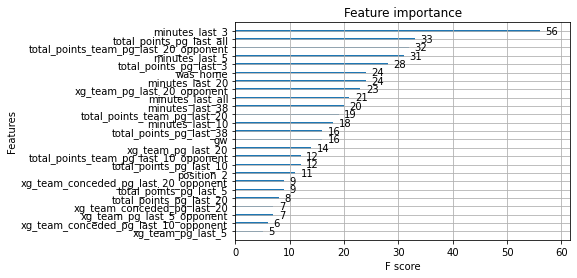

In [19]:
xgb.plot_importance(m, max_num_features=25)
plt.show()

Looks like we're getting a few of the expected goal features in there, which may account for the apparent improvement in performance.

Now we can go ahead and run validation across the whole 2019/20 season.

In [9]:
def xgb_season(df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, 
               dep_var, model_params, valid_season='2021'):
    # empty list for scores
    scores_rmse = []
    scores_mae = []
    valid_len = 6

    for valid_gw in tqdm(range(1,34)):
        
        X_train, y_train, X_test, y_test = xgb_data(df, cat_vars, cont_vars, 
                                                    player_lag_vars, team_lag_vars, dep_var,
                                                    valid_season, valid_gw, valid_len)
    
#         m = xg(X_train, y_train, gamma=model_params['gamma'], learning_rate=model_params['learning_rate'], 
#                max_depth=model_params['max_depth'], n_estimators=model_params['n_estimators'], 
#                subsample=model_params['subsample'])

        m = xg(X_train, y_train)

        preds = m.predict(X_test)
        gw_rmse = r_mse(preds, y_test['total_points'])
        gw_mae = mae(preds, y_test['total_points'])
#         print("GW%d RMSE: %f MAE: %f" % (valid_gw, gw_rmse, gw_mae))

        scores_rmse.append(gw_rmse)
        scores_mae.append(gw_mae)
    
    print('Season RMSE: %f' % np.mean(scores_rmse))
    print('Season MAE: %f' % np.mean(scores_mae))

    return [scores_rmse, scores_mae]

In [20]:
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points', 'xg'], [5, 10, 20])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], [3, 5, 10, 20, 38, 'all'])

# manually add team pg conceded fields for xg 
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if 'xg' in x]

# model_params = {"gamma": 0.321,
#                 "learning_rate": 0.0882, 
#                 "max_depth": 5,
#                 "n_estimators": 70,
#                 "subsample": 0.859}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)

NameError: name 'xgb_season' is not defined

In [ ]:
plt.plot(scores[1])
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1.95, 'Season Avg MAE: %.2f' % np.mean(scores[1]), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

It appears that the performance improvement is sustained across the whole season, which is good to see.

Again, we'll add these scores to the comparison dataset.

In [637]:
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['xgboost'] = scores[1]
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

Finally, in the next notebook we'll move away from tree-based algorithms and try a neural network with embeddings. (Below are my workings trying to find the best inputs for the model).

### Model development notes

Weirdly, the model performs worse when I remove the rows with 0 minutes from training (removing them after I've calculated all the lag values of course), so I keep them in.

In [100]:
# for experimenting with team points split by position
# train_df['total_points_def'] = ((train_df['position'] == 1) | (train_df['position'] == 2)).astype(int) * train_df['total_points']
# train_df['total_points_mid'] = (train_df['position'] == 3).astype(int) * train_df['total_points']
# train_df['total_points_fwd'] = (train_df['position'] == 4).astype(int) * train_df['total_points']

In [ ]:
# for experimenting with expected stats
# only available from 17/18 season
# train_df = train_df[train_df['season'] != '1617']

In [140]:
# original non-xg model (hmmm, seems to be better...)
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

model_params = {"gamma": 0.42,
                "learning_rate": 0.047, 
                "max_depth": 4,
                "n_estimators": 171,
                "subsample": 0.6}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [11:06<00:00, 20.20s/it]

Season RMSE: 2.684082
Season MAE: 1.879299


In [141]:
# original model with above params
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

model_params = {"gamma": 0.325,
                "learning_rate": 0.105, 
                "max_depth": 4,
                "n_estimators": 133,
                "subsample": 0.76}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [08:43<00:00, 15.86s/it]

Season RMSE: 2.692626
Season MAE: 1.880591


In [143]:
# try it with total points for the team and total points conceded for the opposition - bit of improvement
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

# add team conceded fields for opposition
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if pattern.match(x)]

# but remove scored for opposition
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars = [x for x in team_lag_vars if not pattern.match(x)]

print(team_lag_vars)

model_params = {"gamma": 0.42,
                "learning_rate": 0.047, 
                "max_depth": 4,
                "n_estimators": 171,
                "subsample": 0.6}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

['total_points_team_pg_last_all', 'total_points_team_pg_last_1', 'total_points_team_pg_last_2', 'total_points_team_pg_last_3', 'total_points_team_pg_last_4', 'total_points_team_pg_last_5', 'total_points_team_pg_last_10', 'total_points_team_conceded_pg_last_all_opponent', 'total_points_team_conceded_pg_last_1_opponent', 'total_points_team_conceded_pg_last_2_opponent', 'total_points_team_conceded_pg_last_3_opponent', 'total_points_team_conceded_pg_last_4_opponent', 'total_points_team_conceded_pg_last_5_opponent', 'total_points_team_conceded_pg_last_10_opponent']


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [10:22<00:00, 18.86s/it]

Season RMSE: 2.686342
Season MAE: 1.873396


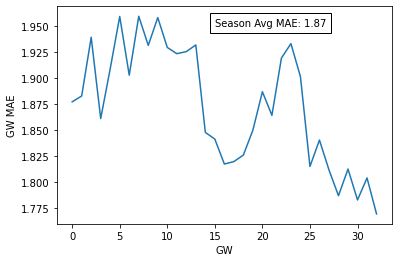

In [144]:
plt.plot(scores[1])
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1.95, 'Season Avg MAE: %.2f' % np.mean(scores[1]), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

In [145]:
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['xgboost'] = scores[1]
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

In [146]:
# try it with total points for the team and total points conceded for the opposition
# but change up the lags a bit - improves little bit
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 3, 5, 10, 20])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

# add team conceded fields
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if pattern.match(x)]

# but remove them for the player's team
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars = [x for x in team_lag_vars if not pattern.match(x)]

print(team_lag_vars)

model_params = {"gamma": 0.42,
                "learning_rate": 0.047, 
                "max_depth": 4,
                "n_estimators": 171,
                "subsample": 0.6}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

['total_points_team_pg_last_all', 'total_points_team_pg_last_3', 'total_points_team_pg_last_5', 'total_points_team_pg_last_10', 'total_points_team_pg_last_20', 'total_points_team_conceded_pg_last_all_opponent', 'total_points_team_conceded_pg_last_3_opponent', 'total_points_team_conceded_pg_last_5_opponent', 'total_points_team_conceded_pg_last_10_opponent', 'total_points_team_conceded_pg_last_20_opponent']


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [09:20<00:00, 16.97s/it]

Season RMSE: 2.683937
Season MAE: 1.868778


In [10]:
# lets compare the last model with and without xg team stats
# But only using data from 2017/18 to have a fair comparison
train_df = train_df[train_df['season'] != '1617']

# first without xg - worse performance as would be expected with less data
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 3, 5, 10, 20])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

# add team conceded fields
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if pattern.match(x)]

# but remove them for the player's team
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars = [x for x in team_lag_vars if not pattern.match(x)]

print(team_lag_vars)

model_params = {"gamma": 0.42,
                "learning_rate": 0.047, 
                "max_depth": 4,
                "n_estimators": 171,
                "subsample": 0.6}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

['total_points_team_pg_last_all', 'total_points_team_pg_last_3', 'total_points_team_pg_last_5', 'total_points_team_pg_last_10', 'total_points_team_pg_last_20', 'total_points_team_conceded_pg_last_all_opponent', 'total_points_team_conceded_pg_last_3_opponent', 'total_points_team_conceded_pg_last_5_opponent', 'total_points_team_conceded_pg_last_10_opponent', 'total_points_team_conceded_pg_last_20_opponent']


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [06:53<00:00, 12.54s/it]

Season RMSE: 2.693712
Season MAE: 1.876261


In [11]:
# then with xg - better rmse, worse mae
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points', 'xg'], ['all', 3, 5, 10, 20])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

# add team conceded fields
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if pattern.match(x)]

pattern = re.compile('xg_team_pg_last_.*_opponent')
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if pattern.match(x)]

# but remove them for the player's team
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars = [x for x in team_lag_vars if not pattern.match(x)]

pattern = re.compile('xg_team_pg_last_.*_opponent')
team_lag_vars = [x for x in team_lag_vars if not pattern.match(x)]

print(team_lag_vars)

model_params = {"gamma": 0.42,
                "learning_rate": 0.047, 
                "max_depth": 4,
                "n_estimators": 171,
                "subsample": 0.6}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

['total_points_team_pg_last_all', 'total_points_team_pg_last_3', 'total_points_team_pg_last_5', 'total_points_team_pg_last_10', 'total_points_team_pg_last_20', 'xg_team_pg_last_all', 'xg_team_pg_last_3', 'xg_team_pg_last_5', 'xg_team_pg_last_10', 'xg_team_pg_last_20', 'total_points_team_conceded_pg_last_all_opponent', 'total_points_team_conceded_pg_last_3_opponent', 'total_points_team_conceded_pg_last_5_opponent', 'total_points_team_conceded_pg_last_10_opponent', 'total_points_team_conceded_pg_last_20_opponent', 'xg_team_conceded_pg_last_all_opponent', 'xg_team_conceded_pg_last_3_opponent', 'xg_team_conceded_pg_last_5_opponent', 'xg_team_conceded_pg_last_10_opponent', 'xg_team_conceded_pg_last_20_opponent']


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [08:52<00:00, 16.14s/it]

Season RMSE: 2.688984
Season MAE: 1.891019


In [12]:
# then with xg - trying max depth of 5, lower estimators, higher learning rate
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points', 'xg'], ['all', 3, 5, 10, 20])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

# add team conceded fields
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if pattern.match(x)]

pattern = re.compile('xg_team_pg_last_.*_opponent')
team_lag_vars += [x.replace('team', 'team_conceded') for x in team_lag_vars if pattern.match(x)]

# but remove them for the player's team
pattern = re.compile('total_points_team_pg_last_.*_opponent')
team_lag_vars = [x for x in team_lag_vars if not pattern.match(x)]

pattern = re.compile('xg_team_pg_last_.*_opponent')
team_lag_vars = [x for x in team_lag_vars if not pattern.match(x)]

print(team_lag_vars)

model_params = {"gamma": 0.42,
                "learning_rate": 0.08, 
                "max_depth": 5,
                "n_estimators": 100,
                "subsample": 0.6}

scores = xgb_season(lag_train_df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, model_params)

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

['total_points_team_pg_last_all', 'total_points_team_pg_last_3', 'total_points_team_pg_last_5', 'total_points_team_pg_last_10', 'total_points_team_pg_last_20', 'xg_team_pg_last_all', 'xg_team_pg_last_3', 'xg_team_pg_last_5', 'xg_team_pg_last_10', 'xg_team_pg_last_20', 'total_points_team_conceded_pg_last_all_opponent', 'total_points_team_conceded_pg_last_3_opponent', 'total_points_team_conceded_pg_last_5_opponent', 'total_points_team_conceded_pg_last_10_opponent', 'total_points_team_conceded_pg_last_20_opponent', 'xg_team_conceded_pg_last_all_opponent', 'xg_team_conceded_pg_last_3_opponent', 'xg_team_conceded_pg_last_5_opponent', 'xg_team_conceded_pg_last_10_opponent', 'xg_team_conceded_pg_last_20_opponent']


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [08:02<00:00, 14.62s/it]

Season RMSE: 2.694500
Season MAE: 1.890661


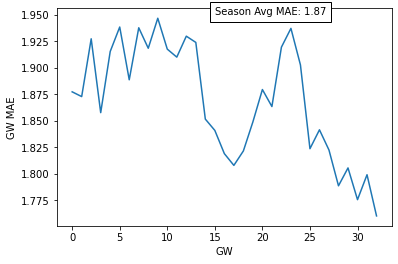

In [147]:
plt.plot(scores[1])
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1.95, 'Season Avg MAE: %.2f' % np.mean(scores[1]), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

In [148]:
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['xgboost'] = scores[1]
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

In [150]:
X_train, y_train, X_test, y_test = xgb_data(lag_train_df, cat_vars, cont_vars, player_lag_vars, 
                                            team_lag_vars, dep_var, valid_season, valid_gw, valid_len)

m = xg(X_train, y_train, gamma=0.42,
                learning_rate=0.047, 
                max_depth=4,
                n_estimators=171,
                subsample=0.6)
preds = m.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.647717
MAE: 1.848925


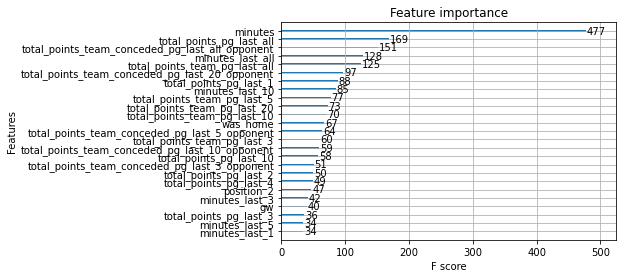

In [151]:
xgb.plot_importance(m, max_num_features=25)
plt.show()

In [438]:
# xg (including conceded) and points for teams
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.620186
MAE: 1.827904


In [512]:
# xg conceded only and points for teams
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.638484
MAE: 1.865984


In [394]:
# xg (including conceded) and points (including conceded) for teams
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.643064
MAE: 1.850276


In [461]:
# only points (including conceded for teams)
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.660879
MAE: 1.878073


In [546]:
# xg (including conceded) and points (excluding opponent) for teams
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.634762
MAE: 1.826365


In [227]:
# includes 0 minute rows
# validation only >0 minute rows
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.620186
MAE: 1.827904


In [232]:
# excludes 0 minute all history rows
# validation only >0 minute rows
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))
print("MAE: %f" % mae(preds, y_test['total_points']))

RMSE: 2.632903
MAE: 1.826975


In [153]:
for i in range(1,5):
    position = 'position_' + str(i)
    mask = X_test[position] == 1
    print(r_mse(xg_reg.predict(X_test[mask]), y_test[mask]['total_points']))

1.67148
1.830329
1.694619
1.910426


In [170]:
mask = (X_test['total_points_pg_last_10'] > X_test['total_points_pg_last_10'].mean() + 2)

In [175]:
sum(X_test['total_points_pg_last_10'] > X_test['total_points_pg_last_10'].mean())/6

102.33333333333333

In [176]:
len(X_test)/6

610.6666666666666

In [4]:
lag_train_df, team_lag_vars = team_lag_features(train_df, ['xg'], ['all', 3, 5, 10, 20])

In [13]:
lag_train_df[['season', 'gw', 'team', 'xg_team_conceded_pg_last_10']][(lag_train_df['season'] == '2021') & (lag_train_df['gw'] == 17)].drop_duplicates().sort_values('xg_team_conceded_pg_last_10')

,season,gw,team,xg_team_conceded_pg_last_10
75895,2021,17,Manchester City,0.59
75912,2021,17,Chelsea,0.77
75896,2021,17,Liverpool,0.97
75931,2021,17,Tottenham Hotspur,1.00
75884,2021,17,Brighton and Hove Albion,1.06
75888,2021,17,Manchester United,1.13
75898,2021,17,Aston Villa,1.17
75890,2021,17,Wolverhampton Wanderers,1.20
75910,2021,17,Newcastle United,1.23
75899,2021,17,Arsenal,1.23


In [556]:
# train_df[(train_df['season'] == '2021')][['team', 'xg']].groupby(['team']).sum()

In [557]:
# train_df[(train_df['team'] == 'Burnley') & (train_df['season'] == '2021')][['player', 'xg']].groupby(['player']).sum()

In [558]:
# train_df[(train_df['team'] == 'Burnley') & (train_df['season'] == '2021') & (train_df['player'] == 'Charlie Taylor')][['gw', 'xg']]